# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [7]:
data.shape

(13150, 10)

In [8]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [10]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [12]:
gini_y = gini(y)
gini_y

0.48734559123306687

In [13]:
gini_X = gini(X)
gini_X

Year          -8.104823e+06
Mileage       -5.480101e+09
M_Camry        1.064840e-01
M_Camry4dr     2.651661e-01
M_CamryBase    2.478018e-02
M_CamryL       9.397273e-02
M_CamryLE      3.588842e-01
M_CamrySE      4.704284e-01
M_CamryXLE     1.981089e-01
dtype: float64

In [17]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

#### test all splits on all features

In [15]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

### Recursively grow the tree 

In [19]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    
    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

### Prediction

In [20]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [26]:
y_pred =tree_predict(X_test, tree)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("accuracy_score: ", accuracy_score(y_test , y_pred))

accuracy_score:  0.8610599078341014


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [29]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [30]:
# show the rows for the first decision tree
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
358005,2013,82246,1,0,0,0,0,0,0
137970,2016,38701,0,0,0,0,1,0,0
272337,2017,14302,0,0,0,0,0,1,0
354913,2017,35268,0,0,0,0,0,1,0
138402,2014,6455,0,0,0,0,0,1,0
144693,2002,89851,0,1,0,0,0,0,0
100267,2009,53337,0,0,0,0,1,0,0
255124,2015,49150,0,0,0,0,0,0,1
344262,2016,20205,0,0,0,0,1,0,0
32368,2017,20006,0,0,0,0,0,1,0


In [31]:
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [32]:
# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_trainB = X_train.iloc[sample]
    y_trainB = y_train.iloc[sample]
    treereg= tree_grow(X_trainB, y_trainB, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred[i] = tree_predict(X_test, treereg)

In [34]:
y_pred

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205915,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2836,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
250833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
126784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
y_pred0 = (y_pred.sum(axis=1) >= (10 / 2)).astype(np.int)

In [38]:
from sklearn import metrics
metrics.f1_score(y_pred0, y_test), metrics.accuracy_score(y_pred0, y_test)

(0.8915617365156926, 0.8670506912442396)

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [39]:
import random
from random import sample

def best_split(X, y, num_pct=10, max_features=1):
    
    List_features=random.sample(range(X_train.shape[1]),max_features)
    
    best_split = [0, 0, 0]  # j, split, gain, max_features
     
    # For features selected
    for j in List_features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [45]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=1):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct, max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction (suma 1 al numerador y 2 al denominador)
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    
    return tree
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10, max_features=0)
tree


{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': -1,
 'n_samples': 8810,
 'gain': 0}

In [46]:
y_pred=tree_predict(X_test, tree)

In [47]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred, normalize=False)
print('Casos clasificados con precision: ' + str(accuracy))

Casos clasificados con precision: 2528


In [48]:
accuracy_scores_mf = []

for mf in range(X_train.shape[1]-1):
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10, max_features=mf)
    y_pred=tree_predict(X_test, tree)
    accuracy = accuracy_score(y_test, y_pred, normalize=False)
    accuracy_scores_mf.append(accuracy)
    print('Num of features ' + str(mf) + ' Casos clasificados con precision: ' + str(accuracy))
print(accuracy_scores_mf)

Num of features 0 Casos clasificados con precision: 2528
Num of features 1 Casos clasificados con precision: 3687
Num of features 2 Casos clasificados con precision: 3672
Num of features 3 Casos clasificados con precision: 3788
Num of features 4 Casos clasificados con precision: 3798
Num of features 5 Casos clasificados con precision: 3757
Num of features 6 Casos clasificados con precision: 3783
Num of features 7 Casos clasificados con precision: 3808
[2528, 3687, 3672, 3788, 3798, 3757, 3783, 3808]


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [49]:
import math

# list of values to try for max_features
N_features = int(round(math.log(X_train.shape[1]),0))
print(N_features)

2


In [50]:
accuracy_scores_ms = []
for i in range(10):
    X_train_n = X_train.iloc[samples[i],:]
    y_train_n = y_train.iloc[samples[i]]
    tree = tree_grow(X_train_n, y_train_n, level=0, min_gain=0.001, max_depth=5, num_pct=10, max_features=N_features)
    y_pred=tree_predict(X_test, tree)
    accuracy = accuracy_score(y_test, y_pred, normalize=False)
    accuracy_scores_ms.append(accuracy)
    print('Sample ' + str(i) + ' Casos clasificados con precision: ' + str(accuracy))

print(accuracy_scores_ms)

Sample 0 Casos clasificados con precision: 3535
Sample 1 Casos clasificados con precision: 3755
Sample 2 Casos clasificados con precision: 2744
Sample 3 Casos clasificados con precision: 3795
Sample 4 Casos clasificados con precision: 3687
Sample 5 Casos clasificados con precision: 3696
Sample 6 Casos clasificados con precision: 3697
Sample 7 Casos clasificados con precision: 3687
Sample 8 Casos clasificados con precision: 3709
Sample 9 Casos clasificados con precision: 3404
[3535, 3755, 2744, 3795, 3687, 3696, 3697, 3687, 3709, 3404]


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rfclf = rf.predict(X_test)
print("accuracy_score: ", accuracy_score(y_test, y_pred_rfclf))

C:\Users\co.nmartinezc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy_score:  0.83963133640553


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [52]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

### Finding max estimators

Text(0, 0.5, 'accuracy_score')

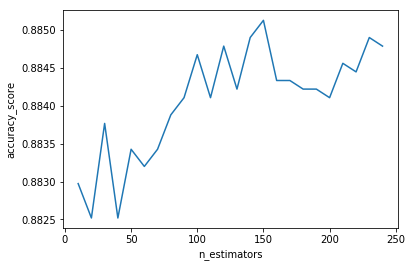

In [53]:
#list of values to try for n_estimators
estimator_range = range(10, 250, 10)
accuracy_scores_estim = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rf  = RandomForestClassifier (n_estimators=estimator, max_depth=7, random_state=1, n_jobs=-1)
    accuracy_scores_estim.append(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(estimator_range, accuracy_scores_estim)
plt.xlabel('n_estimators')
plt.ylabel('accuracy_score')

### Finding max depth

Text(0, 0.5, 'Acurracy')

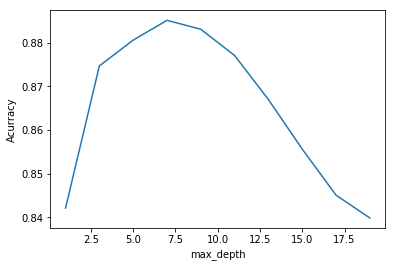

In [54]:
#list of values to try for n_estimators
max_depth_range = range(1, 21,2)

accuracy_scores_depth = []
# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for depth in max_depth_range:
    rf  = RandomForestClassifier (n_estimators=150, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores_depth.append(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean())

plt.plot(max_depth_range, accuracy_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Acurracy')

### Finding max features

Text(0, 0.5, 'Acuracy')

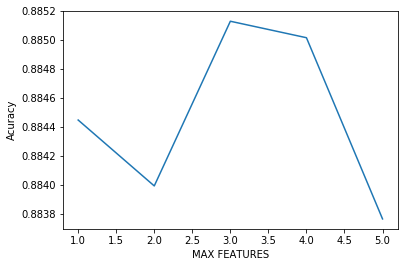

In [60]:
# list of values to try for max_features
feature_range = range(1, 6)

accuracy_scores_featu = []
# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rf  = RandomForestClassifier(n_estimators=150, max_features=feature, max_depth=7, random_state=1, n_jobs=-1)
    accuracy_scores_featu.append(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean())

plt.plot(feature_range, accuracy_scores_featu)
plt.xlabel('MAX FEATURES')
plt.ylabel('Acuracy')

### Training model

In [56]:
rf2 = RandomForestClassifier(n_estimators=150, max_depth=7, max_features=3, random_state=1, n_jobs=-1)
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [62]:
y_pred_rfclf2 = rf2.predict(X_test)
print("accuracy_score: ", accuracy_score(y_test, y_pred_rfclf2))

accuracy_score:  0.8794930875576037
